## Yahoo Finance experimentation

In [5]:
import yfinance as yf
import os
import time
import requests
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
from typing import Dict, List, Any, Optional
from bs4 import BeautifulSoup
import feedparser
import json

from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [6]:
# Get stock information for Apple (AAPL)
ticker = "AAPL"
stock = yf.Ticker(ticker)


info = stock.info
print(f"Company: {info.get('longName', 'N/A')}")
print(f"Sector: {info.get('sector', 'N/A')}")
print(f"Current Price: ${info.get('currentPrice', 'N/A')}")
print(f"Market Cap: ${info.get('marketCap', 'N/A'):,}")

# Get historical data for the last 30 days
hist_data = stock.history(period="1mo")
print(f"\nLatest closing price: ${hist_data.iloc[-1]['Close']:.2f}")
print(f"30-day high: ${hist_data['High'].max():.2f}")
print(f"30-day low: ${hist_data['Low'].min():.2f}")

Company: Apple Inc.
Sector: Technology
Current Price: $255.46
Market Cap: $3,791,126,003,712

Latest closing price: $255.46
30-day high: $257.60
30-day low: $225.95


Data with Moving Average and Daily Returns:
                                Close  20_Day_MA  Daily_Return
Date                                                          
2025-03-27 00:00:00-04:00  223.303421        NaN           NaN
2025-03-28 00:00:00-04:00  217.367935        NaN     -2.658036
2025-03-31 00:00:00-04:00  221.587616        NaN      1.941262
2025-04-01 00:00:00-04:00  222.645035        NaN      0.477201
2025-04-02 00:00:00-04:00  223.343323        NaN      0.313633


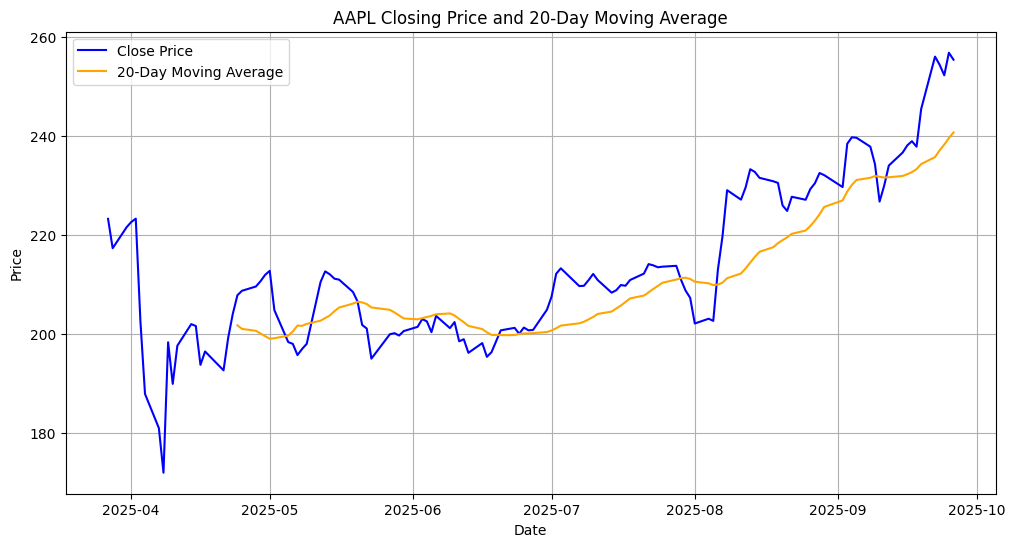

In [7]:
# plot info
symbol = 'AAPL'

stock = yf.Ticker(symbol)
info = stock.info
data = stock.history(period="6mo")

data['20_Day_MA'] = data['Close'].rolling(window=20).mean()

data['Daily_Return'] = data['Close'].pct_change() * 100

print("Data with Moving Average and Daily Returns:")
print(data[['Close', '20_Day_MA', 'Daily_Return']].head())

plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='Close Price', color='blue')
plt.plot(data['20_Day_MA'], label='20-Day Moving Average', color='orange')
plt.title(f'{symbol} Closing Price and 20-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

## Get Complete Stock data 

Reference: https://www.geeksforgeeks.org/python/getting-stock-symbols-with-yfinance-in-python/


In [8]:
from src.financial_tools import StockTools, NewsTools

In [9]:

tsla = StockTools.get_stock_info("TSLA")
pprint(tsla)

{'52_week_high': 488.54,
 '52_week_low': 212.11,
 'avg_volume_30d': 87727386.66666667,
 'beta': 2.065,
 'company_summary': 'Tesla, Inc. designs, develops, manufactures, leases, and '
                    'sells electric vehicles, and energy generation and '
                    'storage systems in the United States, China, and '
                    'internationally. The company operates in two segments, '
                    'Automotive; and Energy Generation and Storage. The '
                    'Automotive segment offers electric vehicles, as well as '
                    'sells automotive regulatory credits; and non-warranty '
                    'after-sales vehicle, used vehicles, body shop and parts, '
                    'supercharging, retail merchandise, and vehicle insurance '
                    'services. Thi',
 'current_price': 440.3999938964844,
 'dividend_yield': None,
 'historical_data': [{'Close': 330.55999755859375,
                      'Dividends': 0.0,
             

## Collect Information from News Sources

In [10]:
msft = NewsTools.get_latest_news("MSFT", limit=10)

# Print information
for news in msft:
    pprint(news)

{'link': 'https://finance.yahoo.com/news/billion-dollar-infrastructure-deals-powering-173527896.html?.tsrc=rss',
 'published': 'Sun, 28 Sep 2025 18:07:00 +0000',
 'source': 'Yahoo Finance',
 'summary': "Here's everything we know about the biggest AI infrastructure "
            'projects, including major spending from Meta, Oracle, Microsoft, '
            'Google, and OpenAI.',
 'title': 'The billion-dollar infrastructure deals powering the AI boom'}
{'link': 'https://finance.yahoo.com/news/constellation-energy-corporation-ceg-bull-154035543.html?.tsrc=rss',
 'published': 'Sun, 28 Sep 2025 15:40:35 +0000',
 'source': 'Yahoo Finance',
 'summary': 'We came across a bullish thesis on Constellation Energy '
            'Corporation on Make Money, Make Time’s Substack by Oliver | MMMT '
            'Wealth. In this article, we will summarize the bulls’ thesis on '
            'CEG. Constellation Energy Corporation’s share was trading at '
            '$321.27 as of September 17th. CEG’s tr